In [36]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [37]:
class EnsembleDeepRVFL:
    """A ensemble deep RVFL classifier or regression.
    Attributes:
        n_nodes: An integer of enhancement node number.
        lam: A floating number of regularization parameter.
        w_random_vec_range: A list, [min, max], the range of generating random weights.
        b_random_vec_range: A list, [min, max], the range of generating random bias.
        random_weights: A Numpy array shape is [n_feature, n_nodes], weights of neuron.
        random_bias: A Numpy array shape is [n_nodes], bias of neuron.
        beta: A Numpy array shape is [n_feature + n_nodes, n_class], the projection matrix.
        activation: A string of activation name.
        n_layer: A integer, N=number of hidden layers.
        data_std: A list, store normalization parameters for each layer.
        data_mean: A list, store normalization parameters for each layer.
        same_feature: A bool, the true means all the features have same meaning and boundary for example: images.
        task_type: A string of ML task type, 'classification' or 'regression'.
    """
    def __init__(self, n_nodes, lam, w_random_vec_range, b_random_vec_range, activation, n_layer, same_feature=False,
                 task_type='classification'):
        assert task_type in ['classification', 'regression'], 'task_type should be "classification" or "regression".'
        self.n_nodes = n_nodes
        self.lam = lam
        self.w_random_range = w_random_vec_range
        self.b_random_range = b_random_vec_range
        self.random_weights = []
        self.random_bias = []
        self.beta = []
        a = Activation()
        self.activation_function = getattr(a, activation)
        self.n_layer = n_layer
        self.data_std = [None] * self.n_layer
        self.data_mean = [None] * self.n_layer
        self.same_feature = same_feature
        self.task_type = task_type

    def train(self, data, label, n_class):
        """
        :param data: Training data.
        :param label: Training label.
        :param n_class: An integer of number of class. In regression, this parameter won't be used.
        :return: No return
        """

        assert len(data.shape) > 1, 'Data shape should be [n, dim].'
        assert len(data) == len(label), 'Label number does not match data number.'
        assert len(label.shape) == 1, 'Label should be 1-D array.'

        n_sample = len(data)
        n_feature = len(data[0])
        h = data.copy()
        data = self.standardize(data, 0)
        if self.task_type == 'classification':
            y = self.one_hot(label, n_class)
        else:
            y = label
        for i in range(self.n_layer):
            h = self.standardize(h, i)  # Normalization data
            self.random_weights.append(self.get_random_vectors(len(h[0]), self.n_nodes, self.w_random_range))
            self.random_bias.append(self.get_random_vectors(1, self.n_nodes, self.b_random_range))
            h = self.activation_function(np.dot(h, self.random_weights[i]) + np.dot(np.ones([n_sample, 1]),
                                                                                    self.random_bias[i]))
            d = np.concatenate([h, data], axis=1)

            h = d

            d = np.concatenate([d, np.ones_like(d[:, 0:1])], axis=1)

            if n_sample > (self.n_nodes + n_feature):
                self.beta.append(np.linalg.inv((self.lam * np.identity(d.shape[1]) + np.dot(d.T, d))).dot(d.T).dot(y))
            else:
                self.beta.append(d.T.dot(np.linalg.inv(self.lam * np.identity(n_sample) + np.dot(d, d.T))).dot(y))

    def predict(self, data, output_prob=False):
        """
        :param data: Predict data.
        :return: When classification, return vote result,  addition result and probability.
                 When regression, return the mean output of edrvfl.
        """
        n_sample = len(data)
        h = data.copy()
        data = self.standardize(data, 0)  # Normalization data
        outputs = []
        for i in range(self.n_layer):
            h = self.standardize(h, i)  # Normalization data
            h = self.activation_function(np.dot(h, self.random_weights[i]) + np.dot(np.ones([n_sample, 1]),
                                                                                    self.random_bias[i]))
            d = np.concatenate([h, data], axis=1)

            h = d

            d = np.concatenate([d, np.ones_like(d[:, 0:1])], axis=1)
            outputs.append(np.dot(d, self.beta[i]))
        if self.task_type == 'classification':
            vote_res = [np.argmax(item, axis=1) for item in outputs]
            vote_res = list(map(np.bincount, list(np.array(vote_res).transpose())))
            vote_res = np.array(list(map(np.argmax, vote_res)))

            add_proba = self.softmax(np.sum(outputs, axis=0))
            add_res = np.argmax(add_proba, axis=1)
            return vote_res, (add_res, add_proba)
        elif self.task_type == 'regression':
            return np.mean(outputs, axis=0)


    def eval(self, data, label):
        """
        :param data: Evaluation data.
        :param label: Evaluation label.
        :return: When classification return vote and addition accuracy.
                 When regression return MAE.
        """

        assert len(data.shape) > 1, 'Data shape should be [n, dim].'
        assert len(data) == len(label), 'Label number does not match data number.'
        assert len(label.shape) == 1, 'Label should be 1-D array.'

        n_sample = len(data)
        h = data.copy()
        data = self.standardize(data, 0)
        outputs = []
        for i in range(self.n_layer):
            h = self.standardize(h, i)  # Normalization data

            h = self.activation_function(np.dot(h, self.random_weights[i]) + np.dot(np.ones([n_sample, 1]),
                                                                                    self.random_bias[i]))
            d = np.concatenate([h, data], axis=1)

            h = d

            d = np.concatenate([d, np.ones_like(d[:, 0:1])], axis=1)

            outputs.append(np.dot(d, self.beta[i]))
        if self.task_type == 'classification':
            vote_res = [np.argmax(item, axis=1) for item in outputs]
            vote_res = list(map(np.bincount, list(np.array(vote_res).transpose())))
            vote_res = np.array(list(map(np.argmax, vote_res)))
            vote_acc = np.sum(np.equal(vote_res, label)) / len(label)

            add_proba = self.softmax(np.sum(outputs, axis=0))
            add_res = np.argmax(add_proba, axis=1)
            add_acc = np.sum(np.equal(add_res, label)) / len(label)

            return vote_acc, add_acc
        elif self.task_type == 'regression':
            pred = np.mean(outputs, axis=0)
            mae = np.mean(np.abs(pred - label))
            return mae

    @staticmethod
    def get_random_vectors(m, n, scale_range):
        x = (scale_range[1] - scale_range[0]) * np.random.random([m, n]) + scale_range[0]
        return x

    @staticmethod
    def one_hot(x, n_class):
        y = np.zeros([len(x), n_class])
        for i in range(len(x)):
            y[i, x[i]] = 1
        return y

    def standardize(self, x, index):
        if self.same_feature is True:
            if self.data_std[index] is None:
                self.data_std[index] = np.maximum(np.std(x), 1/np.sqrt(len(x)))
            if self.data_mean[index] is None:
                self.data_mean[index] = np.mean(x)
            return (x - self.data_mean[index]) / self.data_std[index]
        else:
            if self.data_std[index] is None:
                self.data_std[index] = np.maximum(np.std(x, axis=0), 1/np.sqrt(len(x)))
            if self.data_mean[index] is None:
                self.data_mean[index] = np.mean(x, axis=0)
            return (x - self.data_mean[index]) / self.data_std[index]

    @staticmethod
    def softmax(x):
        return np.exp(x) / np.repeat((np.sum(np.exp(x), axis=1))[:, np.newaxis], len(x[0]), axis=1)


class Activation:
    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.e ** (-x))

    @staticmethod
    def sine(x):
        return np.sin(x)

    @staticmethod
    def hardlim(x):
        return (np.sign(x) + 1) / 2

    @staticmethod
    def tribas(x):
        return np.maximum(1 - np.abs(x), 0)

    @staticmethod
    def radbas(x):
        return np.exp(-(x**2))

    @staticmethod
    def sign(x):
        return np.sign(x)

    @staticmethod
    def relu(x):
        return np.maximum(0, x)

    @staticmethod
    def leaky_relu(x):
        x[x >= 0] = x[x >= 0]
        x[x < 0] = x[x < 0] / 10.0
        return x


In [38]:
num_nodes = 10  # Number of enhancement nodes.
regular_para = 0.001  # Regularization parameter.
weight_random_range = [-1, 1]  # Range of random weights.
bias_random_range = [0, 1]  # Range of random weights.
num_layer = 5  # Number of hidden layers
deep_rvfl = EnsembleDeepRVFL(n_nodes=num_nodes, lam=regular_para, w_random_vec_range=weight_random_range,
                     b_random_vec_range=bias_random_range, activation='relu', n_layer=num_layer, same_feature=False,
                     task_type='regression')

In [39]:
# Load your stock price data
# Assuming your dataset has a 'Date' and 'Close' column
# Adjust this based on your actual dataset structure
df = pd.read_csv('apple_stocks_with_sentiment10.csv', parse_dates=['Date'])
data = df[['Close']]

# Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)
y=data_scaled.copy()
y = y.reshape(-1)
lag = 10  # Adjust the lag as needed

# Create lagged sequences of y as input features
X = np.array([y[i:i+lag] for i in range(len(y)-lag)])

# Corresponding target variable (shifted by lag)
y = y[lag:]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)

# Train the model
deep_rvfl.train(X_train, y_train,0)

# Make predictions
predictions = deep_rvfl.predict(X_test)

# Inverse transform the predictions to the original scale
predictions_original_scale = scaler.inverse_transform(predictions.reshape(-1, 1))

# Inverse transform the y_test to the original scale for evaluation
y_test_original_scale = scaler.inverse_transform(y_test.reshape(-1, 1))


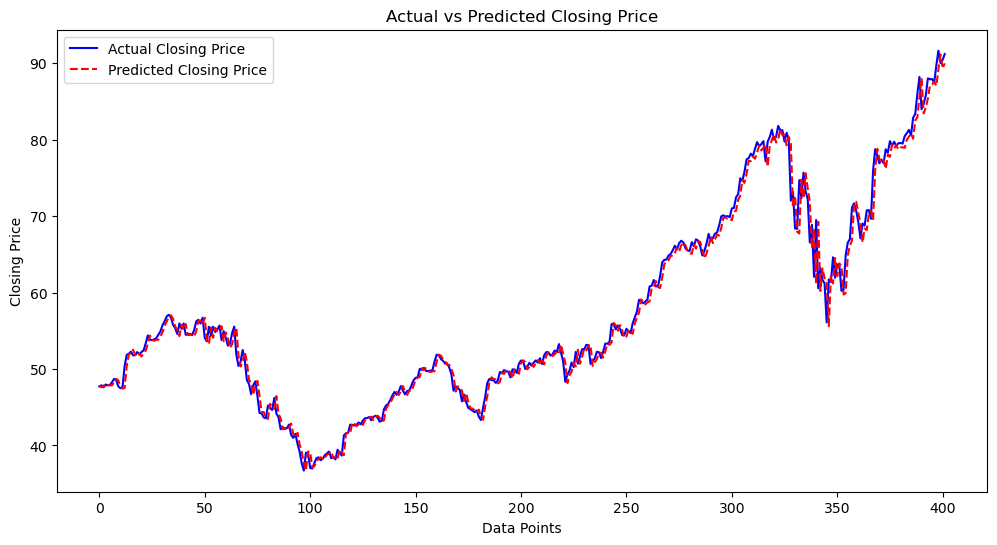

In [40]:
import matplotlib.pyplot as plt
# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(y_test_original_scale, label='Actual Closing Price', color='blue')
plt.plot(predictions_original_scale, label='Predicted Closing Price', color='red', linestyle='dashed')
plt.title('Actual vs Predicted Closing Price')
plt.xlabel('Data Points')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [41]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_test=y_test_original_scale
predictions=predictions_original_scale
# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, predictions))

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, predictions)

# Calculate Relative Root Mean Squared Error (RRMSE)
rrmse = rmse / np.mean(y_test)

# Calculate Relative Mean Absolute Error (RMAE)
rmae = mean_absolute_error(y_test, predictions) / np.mean(y_test)

# Theil's U Statistic
theil_u = np.sqrt(np.mean((predictions - y_test) ** 2) / np.mean(y_test ** 2))

# Kling-Gupta Efficiency (KGE)
def kge(y_true, y_pred):
    std_true, std_pred = np.std(y_true), np.std(y_pred)
    mean_true, mean_pred = np.mean(y_true), np.mean(y_pred)
    correlation = np.corrcoef(y_true, y_pred)[0, 1]
    kge_value = 1 - np.sqrt((correlation - 1) ** 2 + (std_pred / std_true - 1) ** 2 + (mean_pred / mean_true - 1) ** 2)
    return kge_value

kge_value = kge(y_test, predictions)

# Absolute Percentage Bias (APB)
apb = np.mean(np.abs((y_test - predictions) / y_test)) * 100

# Legates metric
legates_metric = 1 - (np.sum((y_test - predictions) ** 2) / np.sum((np.abs(predictions - np.mean(y_test)) + np.abs(y_test - np.mean(y_test))) ** 2))

# Nash-Sutcliffe Efficiency (NSE)
nse = 1 - np.sum((y_test - predictions) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2)

# Willmott's Index of Agreement (d)
d = 1 - (np.sum((np.abs(y_test - predictions)) ** 2) / np.sum((np.abs(predictions - np.mean(y_test)) + np.abs(y_test - np.mean(y_test))) ** 2))

# Standard Deviation of Error (SDE)
sde = np.std(y_test - predictions)

# Maximum Error
max_error = np.max(np.abs(y_test - predictions))

# Minimum Error
min_error = np.min(np.abs(y_test - predictions))

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)

# Calculate R-squared (R2) score
r2 = r2_score(y_test, predictions)

C:\Users\SUJAN\AppData\Roaming\Python\Python311\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\SUJAN\AppData\Roaming\Python\Python311\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\SUJAN\AppData\Roaming\Python\Python311\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


In [42]:
from io import StringIO
table = [
    ["Root Mean Squared Error (RMSE)", rmse],
    ["Mean Squared Error (MSE)", mse],
    ["Mean Absolute Error (MAE)", mae],
    ["Relative Root Mean Squared Error (RRMSE)", rrmse],
    ["Relative Mean Absolute Error (RMAE)", rmae],
    ["Theil\'s U Statistic (TU)", theil_u],
    ["Kling-Gupta Efficiency (KGE)", kge_value],
    ["Absolute Percentage Bias (APB)", apb],
    ["Legates metric (LM)", legates_metric],
    ["Nash-Sutcliffe Efficiency (NSE)", nse],
    ["Willmott's Index of Agreement (d)", d],
    ["Standard Deviation of Error (SDE)", sde],
    ["Legates metric", legates_metric],
    ["Nash-Sutcliffe Efficiency (NSE)", nse],
    ["Maximum Error (emax)", max_error],
    ["Minimum Error(emin)", min_error],
    ["Mean Absolute Error (MAE)", mae],
    ["R-squared (R2) Score", r2]
]
# Create a DataFrame
df = pd.DataFrame(table, columns=["Metric", "Value"])
df_metrics = df.round(3)
df_metrics

,Metric,Value
0,Root Mean Squared Error (RMSE),1.572
1,Mean Squared Error (MSE),2.471
2,Mean Absolute Error (MAE),1.005
3,Relative Root Mean Squared Error (RRMSE),0.027
4,Relative Mean Absolute Error (RMAE),0.018
5,Theil's U Statistic (TU),0.027
6,Kling-Gupta Efficiency (KGE),NaN
7,Absolute Percentage Bias (APB),1.704
8,Legates metric (LM),0.996
9,Nash-Sutcliffe Efficiency (NSE),0.986


In [43]:
from scipy.stats import t
actual_values=y_test
predicted_values=predictions
# Calculate the Mean Bias Error (MBE)
mbe = np.mean(predicted_values - actual_values)

# Calculate the standard deviation of the differences
std_diff = np.std(predicted_values - actual_values)

# Calculate the t-statistic
n = len(actual_values)
t_stat = mbe / (std_diff / np.sqrt(n))

# Degrees of freedom
df = n - 1

# Calculate the p-value
p_value = 2 * (1 - t.cdf(np.abs(t_stat), df))

# Display the t-statistic and p-value
print(f"T-Statistic: {t_stat}")
print(f"P-Value: {p_value}")

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null hypothesis")

T-Statistic: -3.1332288192204714
P-Value: 0.0018559467272434294
Reject the null hypothesis


In [44]:
#HyperOpt

In [45]:
from hyperopt import fmin, tpe, hp, SparkTrials, STATUS_OK, Trials
from math import sqrt

In [46]:
df = pd.read_csv('apple_stocks_with_sentiment10.csv', parse_dates=['Date'])
data = df[['Close']]

# Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)
y=data_scaled.copy()
y = y.reshape(-1)
lag = 10  # Adjust the lag as needed

# Create lagged sequences of y as input features
X = np.array([y[i:i+lag] for i in range(len(y)-lag)])

# Corresponding target variable (shifted by lag)
y = y[lag:]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)

In [16]:
def Obj(params):
    model = EnsembleDeepRVFL(**params,same_feature=False,task_type='regression')
    model.train(X_train, y_train,0)
    y_pred = model.predict(X_test)
    score = sqrt(mean_squared_error(y_test, y_pred))
    print(score)
    return {'loss': score, 'status': STATUS_OK,'Trained_Model': model} 

In [47]:
space ={

        'n_nodes': hp.choice('n_nodes',np.arange(1, 500, 1, dtype=int)),
        'w_random_vec_range': hp.choice('w_random_vec_range',[[-1 ,1],[1 ,-1],
                                                              [0 ,1],[1 ,0],[2, 0],[2 ,1],[1, 2],[-1 ,-1],[-2 ,-1],
                                                            [2,2],[-2,-2],[-2,0]]),
        'b_random_vec_range': hp.choice('b_random_vec_range',[[-1 ,1],[1 ,-1],
                                                              [0 ,1],[1 ,0],[2, 0],[2 ,1],[1, 2],[-1 ,-1],[-2 ,-1],
                                                           [2,2],[-2,-2],[-2,0]]),
        'lam':hp.uniform('lam', 1e-12,1),
        'n_layer': hp.choice('n_layer',np.arange(1, 100, 1, dtype=int)),
        'activation':hp.choice('activation', ['sigmoid','hardlim','sine','tribas','radbas','sign','relu','leaky_relu'])
    
    }

In [48]:
def optimize(trials, space):
    
    best = fmin(Obj, space, algo=tpe.suggest, max_evals=1500)
    return best

trials = Trials()


best_params = optimize(trials, space)

0.01798666703275645                                                                                                    
0.01789361654570951                                                                                                    
0.01853550019185426                                                                                                    
0.01830420527269383                                                                                                    
0.0179422568722141                                                                                                     
0.01788312822940896                                                                                                    
0.017959188317163862                                                                                                   
0.018508444849498942                                                                                                   
0.01802609477250615                     

0.017905863192368924                                                                                                   
0.017897165722310947                                                                                                   
0.01787085518651633                                                                                                    
0.017880897729793763                                                                                                   
0.018968312217247766                                                                                                   
0.01789318483813424                                                                                                    
0.017912701306048235                                                                                                   
0.017917034863221878                                                                                                   
0.01863344683019394                     

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.017959932489656123                                                                                                   
0.01832964617243447                                                                                                    
0.018999398685379126                                                                                                   
0.018171224495502087                                                                                                   
0.017916877860063466                                                                                                   
0.01802278031041039                                                                                                    
0.018328673834514433                                                                                                   
0.018795946249029746                                                                                                   
0.017898573188061997                    

0.01794296168802921                                                                                                    
0.017909827208901344                                                                                                   
0.017963769936632984                                                                                                   
0.017903796926010417                                                                                                   
0.017918392997729814                                                                                                   
0.0179591533160638                                                                                                     
0.018660797179404907                                                                                                   
0.01873782111272156                                                                                                    
0.018018418244046094                    

0.021264644120918504                                                                                                   
0.01934202382095778                                                                                                    
0.019090890355298675                                                                                                   
0.01989004116485268                                                                                                    
0.01895907924857721                                                                                                    
0.017847716515873316                                                                                                   
0.01804807729169102                                                                                                    
0.01789616579378283                                                                                                    
0.018095410832097394                    

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.01793261575135162                                                                                                    
0.017870720756665653                                                                                                   
0.01795743761686951                                                                                                    
0.017899320516758337                                                                                                   
0.0179475403743604                                                                                                     
0.018023392429137634                                                                                                   
0.1960187146372008                                                                                                     
0.017908722555127897                                                                                                   
0.01818459248300153                     

0.018042163489098685                                                                                                   
0.019294162411322757                                                                                                   
0.01796645159812566                                                                                                    
0.01893245427678401                                                                                                    
0.018594455029528553                                                                                                   
0.017918149036737163                                                                                                   
0.01824911885477029                                                                                                    
0.019016793872688845                                                                                                   
0.017942753378561584                    

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.017970557981566233                                                                                                   
0.018761093081138824                                                                                                   
0.019118570885530622                                                                                                   
0.017964973127291797                                                                                                   
0.017936926395526593                                                                                                   
0.02627556816071766                                                                                                    
0.01789731332414559                                                                                                    
0.01943927899440293                                                                                                    
0.017968929475648637                    

0.01908958201095728                                                                                                    
0.01814381190393781                                                                                                    
0.0180029601242567                                                                                                     
 31%|█████████████▏                             | 458/1500 [20:26<58:35,  3.37s/trial, best loss: 0.017830684069666754]

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.01795630993249387                                                                                                    
0.053028722821361465                                                                                                   
0.01884711566839079                                                                                                    
0.017905598520403437                                                                                                   
0.018337205629067394                                                                                                   
0.018967446889256726                                                                                                   
0.09610138266951129                                                                                                    
0.017945794418403556                                                                                                   
0.01803218311286545                     

0.01815135793479248                                                                                                    
0.017861811074752217                                                                                                   
0.018272977570546033                                                                                                   
0.032382123768147794                                                                                                   
0.017908687618936714                                                                                                   
0.018367459458213747                                                                                                   
0.018239008562863125                                                                                                   
0.01784199915392496                                                                                                    
0.01794609578740442                     

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.01789987586904165                                                                                                    
0.017871876959938107                                                                                                   
0.017862337824425097                                                                                                   
0.017888749251777837                                                                                                   
0.017848206429021525                                                                                                   
0.017886839778825107                                                                                                   
 36%|███████████████▌                           | 545/1500 [25:07<13:16,  1.20trial/s, best loss: 0.017830684069666754]

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.01790648572745947                                                                                                    
 36%|███████████████▋                           | 546/1500 [25:09<16:32,  1.04s/trial, best loss: 0.017830684069666754]

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.017876410702243346                                                                                                   
0.017825357740035186                                                                                                   
0.017951770238799725                                                                                                   
 37%|███████████████▋                           | 549/1500 [25:26<59:05,  3.73s/trial, best loss: 0.017825357740035186]

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.017880256361678136                                                                                                   
0.017824925045394752                                                                                                   
0.017824029743743256                                                                                                   
0.017877000390187112                                                                                                   
 37%|███████████████▊                           | 553/1500 [25:42<53:07,  3.37s/trial, best loss: 0.017824029743743256]

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.018453237636518897                                                                                                   
0.017824602685413787                                                                                                   
0.017823480526863007                                                                                                   
0.0178994922934283                                                                                                     
0.017877666739602806                                                                                                   
0.017827262653806894                                                                                                   
0.018538771370022092                                                                                                   
0.017828101787407243                                                                                                   
0.01782292369660301                     

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.017876543615085515                                                                                                   
0.017829832570747606                                                                                                   
 38%|████████████████▎                          | 567/1500 [26:23<52:01,  3.35s/trial, best loss: 0.017822462389949487]

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.017883625239115297                                                                                                   
0.017822461672499505                                                                                                   
0.01782289911406099                                                                                                    
0.017828428839300782                                                                                                   
 38%|████████████████▎                          | 570/1500 [26:40<57:07,  3.69s/trial, best loss: 0.017822461672499505]

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.017873263036032327                                                                                                   
0.017822607345811713                                                                                                   
0.01782259341442526                                                                                                    
0.01783019664730741                                                                                                    
0.017827396851423982                                                                                                   
0.017883725406127315                                                                                                   
0.017822979646828684                                                                                                   
0.01782225429611477                                                                                                    
0.01787926598343716                     

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.017883978991215573                                                                                                   
0.018385448450731486                                                                                                   
0.01789852679348761                                                                                                    
0.01790269744278719                                                                                                    
 39%|█████████████████▏                          | 587/1500 [27:00<17:59,  1.18s/trial, best loss: 0.01782225429611477]

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.017881482819453714                                                                                                   
 39%|█████████████████▏                          | 588/1500 [27:05<37:17,  2.45s/trial, best loss: 0.01782225429611477]

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.01787921626285575                                                                                                    
0.017862032048389986                                                                                                   
0.017882053176656268                                                                                                   
0.017875579692256772                                                                                                   
 39%|█████████████████▎                          | 592/1500 [27:12<24:33,  1.62s/trial, best loss: 0.01782225429611477]

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.017883496290562816                                                                                                   
0.017825777025605203                                                                                                   
 40%|█████████████████▍                          | 594/1500 [27:16<24:40,  1.63s/trial, best loss: 0.01782225429611477]

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.017876508534595787                                                                                                   
0.017881367535836294                                                                                                   
 40%|█████████████████▍                          | 596/1500 [27:29<59:40,  3.96s/trial, best loss: 0.01782225429611477]

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.01788324136219088                                                                                                    
 40%|████████████████▋                         | 597/1500 [27:35<1:08:31,  4.55s/trial, best loss: 0.01782225429611477]

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.017868418492781514                                                                                                   
0.017880781236975497                                                                                                   
 40%|█████████████████▌                          | 599/1500 [27:37<40:40,  2.71s/trial, best loss: 0.01782225429611477]

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.01788481861937829                                                                                                    
0.017881810746924038                                                                                                   
0.017875693317316203                                                                                                   
0.01787639949869694                                                                                                    
 40%|█████████████████▋                          | 603/1500 [27:47<43:57,  2.94s/trial, best loss: 0.01782225429611477]

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.017877223315016018                                                                                                   
0.01788684044644396                                                                                                    
0.01788035499905654                                                                                                    
0.017834397103126516                                                                                                   
0.01812620178177137                                                                                                    
 41%|█████████████████▊                          | 608/1500 [28:05<37:26,  2.52s/trial, best loss: 0.01782225429611477]

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.01787629013089068                                                                                                    
 41%|█████████████████▊                          | 609/1500 [28:07<36:13,  2.44s/trial, best loss: 0.01782225429611477]

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.01787774597041182                                                                                                    
 41%|█████████████████▉                          | 610/1500 [28:09<33:38,  2.27s/trial, best loss: 0.01782225429611477]

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.017875301884949336                                                                                                   
 41%|█████████████████                         | 611/1500 [28:27<1:39:30,  6.72s/trial, best loss: 0.01782225429611477]

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.017881862389112                                                                                                      
 41%|█████████████████▏                        | 612/1500 [28:31<1:24:37,  5.72s/trial, best loss: 0.01782225429611477]

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.017889257514418118                                                                                                   
 41%|█████████████████▏                        | 613/1500 [28:39<1:33:53,  6.35s/trial, best loss: 0.01782225429611477]

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.01787790535531651                                                                                                    
 41%|█████████████████▏                        | 614/1500 [28:47<1:44:22,  7.07s/trial, best loss: 0.01782225429611477]

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.018196920511933525                                                                                                   
 41%|█████████████████▏                        | 615/1500 [28:49<1:20:05,  5.43s/trial, best loss: 0.01782225429611477]

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.01788414946545899                                                                                                    
 41%|█████████████████▏                        | 616/1500 [28:52<1:11:31,  4.85s/trial, best loss: 0.01782225429611477]

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.017883419913747606                                                                                                   
0.017879313858595626                                                                                                   
0.017830728879827916                                                                                                   
0.018009454460752854                                                                                                   
0.01788620112123694                                                                                                    
0.0178803705677099                                                                                                     
0.017871612632394434                                                                                                   
 42%|██████████████████▎                         | 623/1500 [29:22<33:14,  2.27s/trial, best loss: 0.01782225429611477]

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.017876962638412656                                                                                                   
 42%|█████████████████▍                        | 624/1500 [29:32<1:05:28,  4.48s/trial, best loss: 0.01782225429611477]

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.01787632542639977                                                                                                    
0.018459603322492284                                                                                                   
 42%|█████████████████▌                        | 626/1500 [29:43<1:15:12,  5.16s/trial, best loss: 0.01782225429611477]

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.018285249254025974                                                                                                   
0.017885194622049006                                                                                                   
0.018014462270222468                                                                                                   
0.03701773003252882                                                                                                    
0.017884215067011853                                                                                                   
0.017882935599579278                                                                                                   
0.01800218932027181                                                                                                    
0.01794421451842514                                                                                                    
0.0185188629845483                      

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.017890840020490184                                                                                                   
0.017877510380950385                                                                                                   
0.017898388065765016                                                                                                   
0.018001111437311545                                                                                                   
0.018009226224199912                                                                                                   
0.01788681560188415                                                                                                    
0.02219779687928504                                                                                                    
 43%|██████████████████▉                         | 644/1500 [30:57<49:06,  3.44s/trial, best loss: 0.01782225429611477]

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.017887850366187678                                                                                                   
0.017879821676409665                                                                                                   
 43%|██████████████████▉                         | 646/1500 [31:01<36:24,  2.56s/trial, best loss: 0.01782225429611477]

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.018035050947628327                                                                                                   
 43%|██████████████████▉                         | 647/1500 [31:09<56:55,  4.00s/trial, best loss: 0.01782225429611477]

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.01787471921755099                                                                                                    
0.017863919386649878                                                                                                   
0.01795415868726224                                                                                                    
 43%|███████████████████                         | 650/1500 [31:19<55:38,  3.93s/trial, best loss: 0.01782225429611477]

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.017895749605871605                                                                                                   
0.017869175675742106                                                                                                   
0.0178846331154475                                                                                                     
0.018334760397988138                                                                                                   
0.017830601672490013                                                                                                   
0.018000360091951446                                                                                                   
0.017885490203896973                                                                                                   
0.01834995240922305                                                                                                    
0.017880186776180723                    

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.01787651824420387                                                                                                    
 44%|██████████████████▋                       | 667/1500 [32:37<1:00:27,  4.35s/trial, best loss: 0.01782225429611477]

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.017897343528047914                                                                                                   
0.018298974383888948                                                                                                   
0.017991381040598744                                                                                                   
0.018741911348312882                                                                                                   
0.018197202191061256                                                                                                   
0.018023756977383336                                                                                                   
 45%|███████████████████▋                        | 673/1500 [32:59<43:37,  3.17s/trial, best loss: 0.01782225429611477]

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.017875584039647053                                                                                                   
0.017953717087638422                                                                                                   
0.017891201586102363                                                                                                   
0.017892001117029394                                                                                                   
0.017869945039211334                                                                                                   
 45%|███████████████████▉                        | 678/1500 [33:21<51:31,  3.76s/trial, best loss: 0.01782225429611477]

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.017884364310165334                                                                                                   
 45%|███████████████████                       | 679/1500 [33:51<2:36:54, 11.47s/trial, best loss: 0.01782225429611477]

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.01788721375781628                                                                                                    
0.01782232700363737                                                                                                    
0.017930531604649493                                                                                                   
0.01788400981737492                                                                                                    
0.017875573221069557                                                                                                   
0.018407767392197485                                                                                                   
0.018305797472708957                                                                                                   
 46%|████████████████████                        | 686/1500 [34:06<45:57,  3.39s/trial, best loss: 0.01782225429611477]

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.01789063210910241                                                                                                    
0.017888639574314524                                                                                                   
0.018138367024500904                                                                                                   
 46%|████████████████████▏                       | 689/1500 [34:09<27:33,  2.04s/trial, best loss: 0.01782225429611477]

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.017879246092590614                                                                                                   
0.01785672463382831                                                                                                    
0.018003901625761824                                                                                                   
0.01788281151195386                                                                                                    
0.017893794498503757                                                                                                   
0.018077883917208156                                                                                                   
0.01815116240122838                                                                                                    
 46%|████████████████████▍                       | 696/1500 [34:16<13:29,  1.01s/trial, best loss: 0.01782225429611477]

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.01840409163488237                                                                                                    
0.017874230786150774                                                                                                   
 47%|████████████████████▍                       | 698/1500 [34:30<43:16,  3.24s/trial, best loss: 0.01782225429611477]

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.017900161284316787                                                                                                   
 47%|████████████████████▌                       | 699/1500 [34:30<32:37,  2.44s/trial, best loss: 0.01782225429611477]

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.017888700404469934                                                                                                   
0.028642860481617155                                                                                                   
0.017971736179743746                                                                                                   
0.017895256687022992                                                                                                   
0.017869844984418206                                                                                                   
0.017873261431543986                                                                                                   
0.017897342153229585                                                                                                   
0.017824605349859367                                                                                                   
0.01802359972348008                     

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.017888966054512286                                                                                                   
0.017878729645181505                                                                                                   
0.018007552023255                                                                                                      
0.018003335806897804                                                                                                   
0.017908299555479495                                                                                                   
 48%|████████████████████▉                       | 715/1500 [35:14<43:39,  3.34s/trial, best loss: 0.01782225429611477]

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.01789861876872966                                                                                                    
0.01795179799157509                                                                                                    
0.017901210341391582                                                                                                   
0.01792003831766337                                                                                                    
0.01800205486844957                                                                                                    
0.017870280574204256                                                                                                   
0.017890538348468796                                                                                                   
0.017861930806134033                                                                                                   
0.0182988102418751                      

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.017880999025695878                                                                                                   
0.017960003672013003                                                                                                   
0.025715943877832662                                                                                                   
0.018000846221840065                                                                                                   
0.01788991345178148                                                                                                    
0.017952558693117765                                                                                                   
 49%|█████████████████████▍                      | 731/1500 [36:00<44:45,  3.49s/trial, best loss: 0.01782225429611477]

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.017884648052589276                                                                                                   
0.018004075345629835                                                                                                   
0.01791080863068227                                                                                                    
0.01789489183351268                                                                                                    
 49%|█████████████████████▌                      | 735/1500 [36:24<48:58,  3.84s/trial, best loss: 0.01782225429611477]

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.017891654440253982                                                                                                   
 49%|████████████████████▌                     | 736/1500 [36:38<1:28:36,  6.96s/trial, best loss: 0.01782225429611477]

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.017878454930683466                                                                                                   
0.017961885621987087                                                                                                   
 49%|████████████████████▋                     | 738/1500 [36:52<1:21:57,  6.45s/trial, best loss: 0.01782225429611477]

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.017881729634841005                                                                                                   
0.017818060047508695                                                                                                   
0.018345697395742037                                                                                                   
0.017894568305245565                                                                                                   
0.017913048246061037                                                                                                   
 50%|█████████████████████▎                     | 743/1500 [37:04<36:19,  2.88s/trial, best loss: 0.017818060047508695]

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.017884005870676917                                                                                                   
0.01814476302517988                                                                                                    
0.018003858257025558                                                                                                   
0.017964455419010993                                                                                                   
0.017880887005251863                                                                                                   
0.017884046756897504                                                                                                   
0.017885078715174505                                                                                                   
 50%|█████████████████████▍                     | 749/1500 [37:36<53:22,  4.26s/trial, best loss: 0.017818060047508695]

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.01787382396036167                                                                                                    
0.018014265895976527                                                                                                   
0.017883152537638072                                                                                                   
0.01789775488715658                                                                                                    
0.017887791302829144                                                                                                   
0.018029442277817383                                                                                                   
0.01799845952115631                                                                                                    
0.01781732755113601                                                                                                    
0.017876581352807154                    

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.01787614737946191                                                                                                    
 51%|█████████████████████▍                    | 764/1500 [38:31<1:13:37,  6.00s/trial, best loss: 0.01781732755113601]

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.017882830883661095                                                                                                   
0.017885575466317902                                                                                                   
0.017954964109476154                                                                                                   
0.017888563900031042                                                                                                   
0.018039746752854014                                                                                                   
0.018006346004951903                                                                                                   
0.01804742236023278                                                                                                    
0.017888905237290555                                                                                                   
0.01825845126248449                     

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.017963672683398997                                                                                                   
0.01787731244988327                                                                                                    
0.01790397568975666                                                                                                    
0.01791086705009045                                                                                                    
0.017895119235784313                                                                                                   
 52%|██████████████████████▉                     | 780/1500 [39:18<31:12,  2.60s/trial, best loss: 0.01781732755113601]

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.017890817454653568                                                                                                   
0.017877531111583342                                                                                                   
0.01794691857843974                                                                                                    
0.04388235031889635                                                                                                    
0.01789215351637316                                                                                                    
0.017825308433644514                                                                                                   
0.01782884648127772                                                                                                    
0.017825449340171034                                                                                                   
0.017817950950121387                    

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.01787916011602734                                                                                                    
0.01782948114325452                                                                                                    
0.017884783414982383                                                                                                   
 53%|███████████████████████▏                    | 792/1500 [39:30<12:15,  1.04s/trial, best loss: 0.01781732755113601]

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.017887164718663646                                                                                                   
 53%|███████████████████████▎                    | 793/1500 [39:44<50:18,  4.27s/trial, best loss: 0.01781732755113601]

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.017861917189309056                                                                                                   
0.01787883882570364                                                                                                    
0.017890022037379022                                                                                                   
 53%|███████████████████████▎                    | 796/1500 [39:50<36:55,  3.15s/trial, best loss: 0.01781732755113601]

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.017884097665750307                                                                                                   
0.017911985110715085                                                                                                   
0.017874719035114818                                                                                                   
0.017880936002137388                                                                                                   
 53%|███████████████████████▍                    | 800/1500 [39:59<20:19,  1.74s/trial, best loss: 0.01781732755113601]

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.01789384647583312                                                                                                    
0.01782568676832075                                                                                                    
 53%|██████████████████████▍                   | 802/1500 [40:20<1:02:40,  5.39s/trial, best loss: 0.01781732755113601]

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.01787450785814909                                                                                                    
0.01785120349211951                                                                                                    
0.017829675717950896                                                                                                   
0.017884595048729343                                                                                                   
0.018707122309810923                                                                                                   
 54%|███████████████████████▋                    | 807/1500 [40:33<26:31,  2.30s/trial, best loss: 0.01781732755113601]

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.017891030119510758                                                                                                   
 54%|██████████████████████▌                   | 808/1500 [41:04<2:05:20, 10.87s/trial, best loss: 0.01781732755113601]

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.01788285547654223                                                                                                    
0.01789018529485682                                                                                                    
 54%|██████████████████████▋                   | 810/1500 [41:17<1:32:17,  8.03s/trial, best loss: 0.01781732755113601]

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.01789328187752159                                                                                                    
0.018001627733145228                                                                                                   
0.01798471935602729                                                                                                    
 54%|██████████████████████▊                   | 813/1500 [41:37<1:31:57,  8.03s/trial, best loss: 0.01781732755113601]

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.017896025881736232                                                                                                   
0.017889093265273256                                                                                                   
0.017891089012487104                                                                                                   
0.017908347221926378                                                                                                   
0.017831563991148477                                                                                                   
0.01787984489049124                                                                                                    
0.017900788262153872                                                                                                   
0.018058706057686863                                                                                                   
0.01788360049229322                     

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.017892343196497226                                                                                                   
0.01797165972819119                                                                                                    
0.01788839476262247                                                                                                    
0.018403113768388834                                                                                                   
 55%|████████████████████████▍                   | 831/1500 [42:27<31:29,  2.82s/trial, best loss: 0.01781732755113601]

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.017952984344435406                                                                                                   
0.017870790317438705                                                                                                   
0.017910817656911476                                                                                                   
0.017884068692742807                                                                                                   
0.018510934836976883                                                                                                   
0.01790146312766732                                                                                                    
 56%|████████████████████████▌                   | 837/1500 [42:47<55:21,  5.01s/trial, best loss: 0.01781732755113601]

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.017978650747660748                                                                                                   
0.01789113042269073                                                                                                    
0.018081103859654                                                                                                      
0.01786900852049877                                                                                                    
0.017906191103012614                                                                                                   
0.018004470012732574                                                                                                   
0.017875471175204324                                                                                                   
0.018458531733198863                                                                                                   
0.017887909163197633                    

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.017886506060917805                                                                                                   
0.017824857317644938                                                                                                   
0.01788732829972765                                                                                                    
0.017911121765214123                                                                                                   
0.01787747307637068                                                                                                    
0.0178741522096349                                                                                                     
0.023207690628720353                                                                                                   
0.01790355360246236                                                                                                    
0.017898304934677072                    

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.017874527190331835                                                                                                   
0.017900677593967473                                                                                                   
0.018338598176583655                                                                                                   
0.017963100184067                                                                                                      
 58%|█████████████████████████▍                  | 867/1500 [44:35<40:28,  3.84s/trial, best loss: 0.01781732755113601]

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.017897755518748757                                                                                                   
0.01801456360670824                                                                                                    
0.017903616905113075                                                                                                   
 58%|█████████████████████████▌                  | 870/1500 [44:47<39:18,  3.74s/trial, best loss: 0.01781732755113601]

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.017874625730768517                                                                                                   
0.01792207899830376                                                                                                    
0.017895289927575372                                                                                                   
0.017888108414742164                                                                                                   
0.01797238756757416                                                                                                    
0.017865547412739425                                                                                                   
0.01787943329100172                                                                                                    
0.01803631125674442                                                                                                    
0.01783295101457679                     

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.017946185054779608                                                                                                   
 60%|██████████████████████████▎                 | 898/1500 [46:10<35:07,  3.50s/trial, best loss: 0.01781732755113601]

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.017875668605703356                                                                                                   
0.017908067575905087                                                                                                   
0.018047676940673038                                                                                                   
0.01829518374541515                                                                                                    
0.017894802190738388                                                                                                   
 60%|██████████████████████████▍                 | 903/1500 [46:26<24:53,  2.50s/trial, best loss: 0.01781732755113601]

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.01788051665477485                                                                                                    
0.02189105282315894                                                                                                    
0.01788587566962873                                                                                                    
0.017898223860972926                                                                                                   
0.018027110973215032                                                                                                   
0.01787139594365789                                                                                                    
0.01789295684125934                                                                                                    
0.017882067328972056                                                                                                   
0.01786235816359556                     

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.01857506105615592                                                                                                    
0.017903992032274524                                                                                                   
 61%|██████████████████████████▊                 | 915/1500 [47:14<47:18,  4.85s/trial, best loss: 0.01781732755113601]

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.01788681472108828                                                                                                    
0.017952280146918423                                                                                                   
0.01832932732093289                                                                                                    
0.017881059445666703                                                                                                   
0.031152724149368236                                                                                                   
0.017896362023804326                                                                                                   
0.019109633413137303                                                                                                   
0.017876093369822033                                                                                                   
0.01796362741661636                     

C:\Users\SUJAN\AppData\Local\Temp\ipykernel_28728\3362559442.py:183: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.e ** (-x))



0.017874643154342906                                                                                                   
0.01781920772515577                                                                                                    
0.017884943177103436                                                                                                   
0.01789127502541463                                                                                                    
0.01796078962744745                                                                                                    
0.017886912082240934                                                                                                   
0.017965122579080995                                                                                                   
0.01787485844632536                                                                                                    
0.017957485386328097                    

0.017811660507771856                                                                                                   
0.017892691560389192                                                                                                   
0.017853280505208555                                                                                                   
0.01791563381620547                                                                                                    
0.017899233493460894                                                                                                   
0.01788057062358411                                                                                                    
0.017878977925615058                                                                                                   
0.0179023083033166                                                                                                     
0.01787874080669385                     

0.017879867426139864                                                                                                   
0.017876955367281025                                                                                                   
0.017827682543050595                                                                                                   
0.017896520747317467                                                                                                   
0.017886869464302076                                                                                                   
0.017879327877352674                                                                                                   
0.017868308857029603                                                                                                   
0.01787517406852991                                                                                                    
0.01788391716174823                     

0.017876042016059333                                                                                                   
0.017879449885682665                                                                                                   
0.017879466223449575                                                                                                   
0.017895037145911338                                                                                                   
0.01787159974800818                                                                                                    
0.017883746088332354                                                                                                   
0.017868530604381754                                                                                                   
0.017882706637732296                                                                                                   
0.01781496713053494                     

0.017894838829868125                                                                                                   
0.017970258144852827                                                                                                   
0.017803342341763076                                                                                                   
0.0178811121515547                                                                                                     
0.018457144232851365                                                                                                   
0.01804494022515925                                                                                                    
0.01781316238927272                                                                                                    
0.018025255194496943                                                                                                   
0.017909695225930194                    

0.017891234388063608                                                                                                   
0.01786504403192031                                                                                                    
0.017934746698462692                                                                                                   
0.017820581320548742                                                                                                   
0.017955359892345552                                                                                                   
0.017877965082745417                                                                                                   
0.017883045539851563                                                                                                   
0.017891847412249938                                                                                                   
0.01789364976229271                     

0.017894695540928575                                                                                                   
0.017998605993980506                                                                                                   
0.01794464604750223                                                                                                    
0.017874588469104395                                                                                                   
0.017876640799563876                                                                                                   
0.01789304145918757                                                                                                    
0.017870822582766708                                                                                                   
0.017875835102309487                                                                                                   
0.017811936162987096                    

0.01784836617964409                                                                                                    
0.017943865969958877                                                                                                   
0.017906153781421488                                                                                                   
0.017866881893362482                                                                                                   
0.01805762201785577                                                                                                    
0.01803888439488573                                                                                                    
0.017968965113590914                                                                                                   
0.017881855873209843                                                                                                   
0.01821351639111098                     

0.017834414679360748                                                                                                   
0.01881795634200313                                                                                                    
0.017861159831452325                                                                                                   
0.01791683290405547                                                                                                    
0.017873710766495174                                                                                                   
0.017891878217035525                                                                                                   
0.017880310903627444                                                                                                   
0.017920924233836445                                                                                                   
0.01788962856508934                     

In [49]:
from hyperopt import hp, fmin, tpe, space_eval,Trials
# Return the best parameters
best_hp=space_eval(space, best_params)
best_hp

{'activation': 'hardlim',
 'b_random_vec_range': (-2, 0),
 'lam': 0.9450136957371148,
 'n_layer': 1,
 'n_nodes': 265,
 'w_random_vec_range': (-2, 0)}

In [50]:
num_nodes = best_hp['n_nodes']
activation = best_hp['activation']
regular_para = best_hp['lam']
num_layer = best_hp['n_layer']
weight_random_range = best_hp['w_random_vec_range']
bias_random_range = best_hp['b_random_vec_range']


In [51]:
deep_rvfl = EnsembleDeepRVFL(n_nodes=num_nodes, lam=regular_para, w_random_vec_range=weight_random_range,
                             b_random_vec_range=bias_random_range, activation='relu', 
                             n_layer=num_layer, same_feature=False,
                     task_type='regression')

In [52]:
# Train the model
deep_rvfl.train(X_train, y_train,0)

# Make predictions
predictions = deep_rvfl.predict(X_test)

# Inverse transform the predictions to the original scale
predictions_original_scale = scaler.inverse_transform(predictions.reshape(-1, 1))

# Inverse transform the y_test to the original scale for evaluation
y_test_original_scale = scaler.inverse_transform(y_test.reshape(-1, 1))

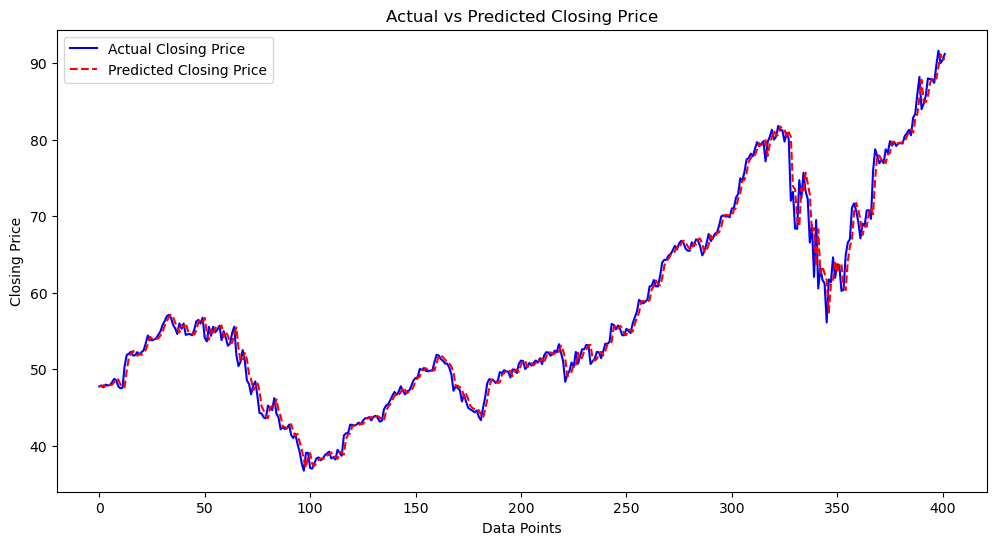

In [53]:
import matplotlib.pyplot as plt
# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(y_test_original_scale, label='Actual Closing Price', color='blue')
plt.plot(predictions_original_scale, label='Predicted Closing Price', color='red', linestyle='dashed')
plt.title('Actual vs Predicted Closing Price')
plt.xlabel('Data Points')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [54]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_test=y_test_original_scale.copy()
predictions=predictions_original_scale.copy()
# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, predictions))

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, predictions)

# Calculate Relative Root Mean Squared Error (RRMSE)
rrmse = rmse / np.mean(y_test)

# Calculate Relative Mean Absolute Error (RMAE)
rmae = mean_absolute_error(y_test, predictions) / np.mean(y_test)

# Theil's U Statistic
theil_u = np.sqrt(np.mean((predictions - y_test) ** 2) / np.mean(y_test ** 2))

# Kling-Gupta Efficiency (KGE)
def kge(y_true, y_pred):
    std_true, std_pred = np.std(y_true), np.std(y_pred)
    mean_true, mean_pred = np.mean(y_true), np.mean(y_pred)
    correlation = np.corrcoef(y_true, y_pred)[0, 1]
    kge_value = 1 - np.sqrt((correlation - 1) ** 2 + (std_pred / std_true - 1) ** 2 + (mean_pred / mean_true - 1) ** 2)
    return kge_value

kge_value = kge(y_test, predictions)

# Absolute Percentage Bias (APB)
apb = np.mean(np.abs((y_test - predictions) / y_test)) * 100

# Legates metric
legates_metric = 1 - (np.sum((y_test - predictions) ** 2) / np.sum((np.abs(predictions - np.mean(y_test)) + np.abs(y_test - np.mean(y_test))) ** 2))

# Nash-Sutcliffe Efficiency (NSE)
nse = 1 - np.sum((y_test - predictions) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2)

# Willmott's Index of Agreement (d)
d = 1 - (np.sum((np.abs(y_test - predictions)) ** 2) / np.sum((np.abs(predictions - np.mean(y_test)) + np.abs(y_test - np.mean(y_test))) ** 2))

# Standard Deviation of Error (SDE)
sde = np.std(y_test - predictions)

# Maximum Error
max_error = np.max(np.abs(y_test - predictions))

# Minimum Error
min_error = np.min(np.abs(y_test - predictions))

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)

# Calculate R-squared (R2) score
r2 = r2_score(y_test, predictions)

C:\Users\SUJAN\AppData\Roaming\Python\Python311\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\SUJAN\AppData\Roaming\Python\Python311\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\SUJAN\AppData\Roaming\Python\Python311\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


In [55]:
from io import StringIO
table = [
    ["Root Mean Squared Error (RMSE)", rmse],
    ["Mean Squared Error (MSE)", mse],
    ["Mean Absolute Error (MAE)", mae],
    ["Relative Root Mean Squared Error (RRMSE)", rrmse],
    ["Relative Mean Absolute Error (RMAE)", rmae],
    ["Theil\'s U Statistic (TU)", theil_u],
    ["Kling-Gupta Efficiency (KGE)", kge_value],
    ["Absolute Percentage Bias (APB)", apb],
    ["Legates metric (LM)", legates_metric],
    ["Nash-Sutcliffe Efficiency (NSE)", nse],
    ["Willmott's Index of Agreement (d)", d],
    ["Standard Deviation of Error (SDE)", sde],
    ["Legates metric", legates_metric],
    ["Nash-Sutcliffe Efficiency (NSE)", nse],
    ["Maximum Error (emax)", max_error],
    ["Minimum Error(emin)", min_error],
    ["Mean Absolute Error (MAE)", mae],
    ["R-squared (R2) Score", r2]
]
# Create a DataFrame
df = pd.DataFrame(table, columns=["Metric", "Value"])
df_metrics = df.round(3)
df_metrics

,Metric,Value
0,Root Mean Squared Error (RMSE),1.478
1,Mean Squared Error (MSE),2.183
2,Mean Absolute Error (MAE),0.939
3,Relative Root Mean Squared Error (RRMSE),0.026
4,Relative Mean Absolute Error (RMAE),0.016
5,Theil's U Statistic (TU),0.025
6,Kling-Gupta Efficiency (KGE),NaN
7,Absolute Percentage Bias (APB),1.626
8,Legates metric (LM),0.997
9,Nash-Sutcliffe Efficiency (NSE),0.987
